# Recommendation Systems

- **`Content Based Recommendation`**
  - Recommends items based on their characteristics and a user's preferences for those characteristics.
  - For example, a movie recommender might suggest films with similar genres or actors to ones a user has liked in the past.

- **`Collaborative Filtering`**
  - recommends items based on the preferences of similar users.
  - It doesn't require knowledge of the items themselves, just information about user interactions.
  - For example, a music streaming service might recommend songs that other users with similar tastes have enjoyed.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
mlxtend  : 0.23.1
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm
from typing import Generator


def process_text(text: list[str]) -> list[str]:
    """
    Process a list of text lines to extract product IDs and categories.

    Parameters
    ----------
    text : list[str]
        A list of strings representing lines of text to process.

    Returns
    -------
    list[str]
        A list of strings, each containing a product ID and its associated category.
    """
    result: list[str] = []
    # Starts with a capital letter and then lowercase letters
    pattern: re.Pattern[str] = re.compile(r"^[A-Z][a-z]+")
    prod_id: str = ""

    for line in tqdm(text, desc="Processing Text", unit="line", ncols=100):
        line: str = line.strip()
        if len(line.split(",")) == 1 and not pattern.match(line):
            prod_id = line
        elif pattern.match(line):
            result.append(f"{prod_id}: {line}")

    return result


def parse_keys_values(filename: str) -> Generator[dict[str, str], None, None]:
    """
    Parse key-value pairs from a file.

    Parameters
    ----------
    filename : str
        The path to the file to be parsed.

    Yields
    ------
    dict[str, str]
        A dictionary containing key-value pairs parsed from the file.

    """
    entry: dict[str, str] = {}
    f = open(filename, "rb")

    # Iterate over all lines in the file.
    for l in f:
        l = l.strip()
        # The key/value pairs are separated by a colon.
        colonPos: int = l.find(b":")
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        key: str = l[:colonPos].decode("latin-1")
        value: str = l[colonPos + 2 :].decode("latin-1")
        entry[key] = value
    yield entry


def read_reviews(path: str, num: int = -1) -> pl.DataFrame:
    """
    Read reviews from a file and return them as a Polars DataFrame.

    Parameters
    ----------
    path : str
        The path to the file containing the reviews.
    num : int, optional
        The number of reviews to read. If -1, read all reviews. Default is -1.

    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing the parsed reviews.

    """
    i: int = 0
    df: dict[int, dict[str, str]] = {}
    for d in parse_keys_values(path):
        df[i] = d
        i += 1
        if i == num:
            break
    result: pl.DataFrame = pl.DataFrame([x for x in df.values()])
    return result

In [4]:
fp: str = "../../data/prod_categories.parquet"

prod_categories: pl.DataFrame = pl.read_parquet(fp)
print(f"{prod_categories.shape = }")
prod_categories.head(3)

prod_categories.shape = (2437878, 2)


product_id,product_category
str,str
"""B00005AL88""","""Cookware, Cookware Sets, Kitchen & Dining, Home & Kitchen"""
"""B000002ERS""","""Music, World Music Music, Latin Music"""
"""B000PR126O""","""Jewelry, Charms"""


In [5]:
# Set verbosity level
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [6]:
fp: str = "../../data/Music_small.parquet"
df_music: pl.DataFrame = pl.read_parquet(fp).sample(
    fraction=0.3, shuffle=True, seed=123
)
print(f"{df_music.shape = }")
df_music.head(2)

df_music.shape = (1918905, 10)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004VVN6""","""Elvis - '68 Comeback Special (1968)""","""unknown""","""A1VMEBPPFUU0J7""","""C. Manson""","""1/1""",5.0,"""960595200""","""No Strap for You""","""I could easily slobber all over my blue suede shoes praising this one, but let me just sum it up by…"
"""B000003BD7""","""A Christmas Gift for You from Phil Spector""","""12.14""","""A13HAJYO0FO0LQ""","""Aj Watson""","""3/5""",5.0,"""1258416000""","""Great in mono""","""My copy of Sony's remaster of this Xmas classic arrived today. I have to say, this 2009 remaster fr…"


### Data Cleaning

In [7]:
df_music.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004VVN6""","""Elvis - '68 Comeback Special (1968)""","""unknown""","""A1VMEBPPFUU0J7""","""C. Manson""","""1/1""",5.0,"""960595200""","""No Strap for You""","""I could easily slobber all over my blue suede shoes praising this one, but let me just sum it up by…"
"""B000003BD7""","""A Christmas Gift for You from Phil Spector""","""12.14""","""A13HAJYO0FO0LQ""","""Aj Watson""","""3/5""",5.0,"""1258416000""","""Great in mono""","""My copy of Sony's remaster of this Xmas classic arrived today. I have to say, this 2009 remaster fr…"
"""B000AMUUSU""","""Hello Waveforms""","""unknown""","""A2X192PNI73QWI""","""David L. Reade""","""0/5""",5.0,"""1131408000""","""You are absolutely right.....""","""I'm referring to the comments of the first reviewer, he's right: what's up with Orbit's website not…"
"""B00000EGZR""","""About Face""","""unknown""","""A1P6559HS6RN6""","""Dustbuny48 ""Music Soul""""","""2/2""",4.0,"""1189296000""","""A most wonderful surprise""","""While most modern day Pink Floyd fans only know David Gilmour as a major contributor to their later…"
"""B0000013GH""","""Secrets""","""11.98""","""A105NYRPZGNJ19""","""F. Juergens""","""3/17""",2.0,"""1046217600""","""Overrated!""","""To me, Toni Braxton is one of the most overrated singers of the 90s, and this album is far worse th…"


In [8]:
# Check for unique product and userId entries
p_id: str = "B000058A81"
user_id: str = "A18C9SNLZWVBIE"
df_music.filter((pl.col("productId").eq(p_id) & pl.col("userId").eq(user_id)))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str


In [9]:
# We want a:
# unique user-product pair.
# unique user-title pair.
# unique product-title pair.

print(f"[Before data cleaning]: {df_music.shape}")

# Remove duplicates
df_music_cleaned: pl.DataFrame = df_music.unique(subset=["userId", "productId"])
# df_music_cleaned = df_music_cleaned.unique(subset=["userId", "title"])
# df_music_cleaned = df_music_cleaned.unique(subset=["productId", "title"])

print(f"[After data cleaning]: {df_music_cleaned.shape}")

[Before data cleaning]: (1918905, 10)
[After data cleaning]: (1638866, 10)


In [10]:
df_music_cleaned.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B0002F9BL2""","""Live at Benaroya Hall""","""unknown""","""A2UV7HC7IYME21""","""pearl jam fan""","""7/7""",5.0,"""1124755200""","""One Of Their Best""","""I gotta admit, this is the one I keep coming back to out of all the bootlegs I own. It just has a g…"
"""B0000523JR""","""Feel the Presence of Angels""","""unknown""","""A2VLW5OCNLQ3KP""","""Melissa Slatin""","""0/0""",5.0,"""1155945600""","""Magical Music""","""I am an avid Dik Darnell fan as I heard of him years ago, when cassette tapes were still popular. I…"
"""B000002GYD""","""Hejira""","""unknown""","""A6P1YY7PJVO3K""","""K. Parsons ""Hailing from the mountaintop!""""","""8/8""",5.0,"""1144368000""","""Yeah, it doesn't get any better than this...""","""Evocative. Visceral. Soothing. Sophisticated. BRILLIANT! I don't care what the ""critics"" had to say…"
"""B000069HSV""","""Elvis - The Great Performances, Vol. 1 - Center Stage (1990)""","""10.73""","""A20GPZXU014DO9""","""D. Passamonti ""4boys&agirl""""","""7/8""",5.0,"""1100908800""","""great videos""","""Have all three videos and love each one especially the third. The live performance of the song Love…"
"""B00008RGZD""","""Music Through Heartsongs""","""unknown""","""A1923RIA1S9Q7B""","""J""","""3/4""",4.0,"""1050537600""","""Gilman's voice continues to thrive, but material gets old""","""On his 4th studio LP, Gilman continues to produce vocals that would intimidate most adults, but the…"


In [11]:
# Check the unique userIDs
df_music_cleaned["userId"].value_counts(sort=True).head()

userId,count
str,u32
"""unknown""",109297
"""A9Q28YTLYREO7""",3097
"""A2WQY1B8ZS7QRZ""",1534
"""A8IFUOL8S9BZC""",1529
"""A2U49LUUY4IKQQ""",1356


In [12]:
# Check the unique title
df_music_cleaned["title"].value_counts(sort=True).head(20)

title,count
str,u32
"""Greatest Hits""",6031
"""Best of""",3488
"""St. Anger""",2869
"""Kind of Blue""",2734
"""Hybrid Theory""",2576
"""No Strings Attached""",2251
"""Come Away With Me""",2110
"""Let Go""",1756
"""Fallen""",1736


In [13]:
# Drop the unwanted userIDs
rem_str: str = "unknown"
rem_str_2: str = ""
print(f"[Before data cleaning]: {df_music_cleaned.shape}")
df_music_cleaned = df_music_cleaned.filter(pl.col("userId").ne(rem_str))
df_music_cleaned = df_music_cleaned.filter(pl.col("title").ne(rem_str_2))
print(f"[After data cleaning]: {df_music_cleaned.shape}")

[Before data cleaning]: (1638866, 10)
[After data cleaning]: (1529158, 10)


In [14]:
df_music_cleaned.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B0002F9BL2""","""Live at Benaroya Hall""","""unknown""","""A2UV7HC7IYME21""","""pearl jam fan""","""7/7""",5.0,"""1124755200""","""One Of Their Best""","""I gotta admit, this is the one I keep coming back to out of all the bootlegs I own. It just has a g…"
"""B0000523JR""","""Feel the Presence of Angels""","""unknown""","""A2VLW5OCNLQ3KP""","""Melissa Slatin""","""0/0""",5.0,"""1155945600""","""Magical Music""","""I am an avid Dik Darnell fan as I heard of him years ago, when cassette tapes were still popular. I…"
"""B000002GYD""","""Hejira""","""unknown""","""A6P1YY7PJVO3K""","""K. Parsons ""Hailing from the mountaintop!""""","""8/8""",5.0,"""1144368000""","""Yeah, it doesn't get any better than this...""","""Evocative. Visceral. Soothing. Sophisticated. BRILLIANT! I don't care what the ""critics"" had to say…"
"""B000069HSV""","""Elvis - The Great Performances, Vol. 1 - Center Stage (1990)""","""10.73""","""A20GPZXU014DO9""","""D. Passamonti ""4boys&agirl""""","""7/8""",5.0,"""1100908800""","""great videos""","""Have all three videos and love each one especially the third. The live performance of the song Love…"
"""B00008RGZD""","""Music Through Heartsongs""","""unknown""","""A1923RIA1S9Q7B""","""J""","""3/4""",4.0,"""1050537600""","""Gilman's voice continues to thrive, but material gets old""","""On his 4th studio LP, Gilman continues to produce vocals that would intimidate most adults, but the…"


In [15]:
# Check the unique titles
# df_music_cleaned["title"].value_counts(sort=True).slice(20, 40)
titles: list[dict[str, int]] = (
    df_music_cleaned["title"].value_counts(sort=True).to_dicts()
)
titles = sorted(titles, key=lambda x: x["title"], reverse=True)
titles[980:1000]

[{'title': 'Yundi Li: Vienna Recital - Scarlatti / Mozart / Schumann / Liszt',
  'count': 5},
 {'title': 'Yundi Li: Live in Concert (2005)', 'count': 7},
 {'title': 'Yunagi Loop', 'count': 1},
 {'title': 'Yummy, Yummy, Yummy', 'count': 5},
 {'title': 'Yummy Yummy: Best of Bubble Gum Music', 'count': 1},
 {'title': 'Yummy Yummy Yummy', 'count': 1},
 {'title': 'Yummy Yummy (Blister)', 'count': 22},
 {'title': 'Yummy Yummy', 'count': 57},
 {'title': 'Yummy', 'count': 1},
 {'title': "Yumeji's Theme", 'count': 1},
 {'title': 'Yume No Oka', 'count': 1},
 {'title': 'Yume Bitsu', 'count': 1},
 {'title': 'Yuletunes', 'count': 2},
 {'title': 'Yuletide in the Shire', 'count': 4},
 {'title': 'Yuletide Joy', 'count': 4},
 {'title': 'Yuletide Guitars', 'count': 1},
 {'title': 'Yuletide Guitar', 'count': 1},
 {'title': 'Yuletide Fires', 'count': 1},
 {'title': 'Yuletide Classics', 'count': 2},
 {'title': 'Yulesville', 'count': 1}]

In [16]:
text: str = "zoo rave"
df_music_cleaned.filter(pl.col("title").str.to_lowercase().str.contains(text))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00000E9GW""","""Zoo Rave 2""","""2.99""","""A1DTAWBG9UTVWR""","""""mn2nmixr""""","""2/2""",5.0,"""1015200000""","""Perfecto""","""First of all, this album is from 1993, so late 90's is impossible. A great album packed with a vari…"
"""B00000098Q""","""Zoo Rave, Vol. 1 [Vinyl]""","""unknown""","""A1SFF3DSLJVIEW""","""Ross H. Goodwin ""Digitally Natured Audio""""","""5/5""",5.0,"""1136678400""","""Nostalgic Frequencies....""","""I originally bought this as a cassette in 93. Back then I loved every moment of the cd, in retrospe…"
"""B00000099A""","""Zoo Rave II""","""unknown""","""A1DTAWBG9UTVWR""","""""mn2nmixr""""","""2/2""",5.0,"""1015200000""","""Perfecto""","""First of all, this album is from 1993, so late 90's is impossible. A great album packed with a vari…"
"""B00000E9GW""","""Zoo Rave 2""","""2.99""","""A3F6L8ANIGHCAV""","""B. Lynch ""the_onewhoknows""""","""1/2""",5.0,"""981590400""","""Worth seeking out""","""While the tunes here are all from the mid to late 1990's, they were cutting-edge in nearly any sens…"
"""B00000099A""","""Zoo Rave II""","""unknown""","""A3010KGHW804ZD""","""Craig Froehle""","""1/1""",3.0,"""980035200""","""Typical dance techno -- not bad, not great""","""This disc was published by BMG records and all tracks were produced by the artists specifically for…"


### Apply Levenshtein Distance

- Levenshtein Distance is a string metric used to measure the difference between two sequences.
- It calculates the `minimum number of single-character edits` (`insertions`, `deletions`, or `substitutions`) required to change one word into another.
- It provides a quantitative measure of how dissimilar two strings are, which can be very useful in recommendation systems, especially for handling `typos` or `slight variations` in text input.
- It's an effective way to find close matches even when there are small differences between strings.

In [17]:
def levenshtein_distance(s1: str, s2: str) -> int:
    """
    Calculate the Levenshtein distance between two strings.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    int
        The Levenshtein distance between s1 and s2.

    Example
    -------
    >>> levenshtein_distance("kitten", "sitting")
    3
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row: list[int] = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row: list[int] = [i + 1]
        for j, c2 in enumerate(s2):
            insertions: int = previous_row[j + 1] + 1
            deletions: int = current_row[j] + 1
            substitutions: int = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


def compute_string_similarity(s1: str, s2: str) -> float:
    """
    Compute the similarity between two strings based on Levenshtein distance.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    float
        A similarity score between 0 and 1, where 1 indicates identical strings.
    """
    distance: int = levenshtein_distance(s1, s2)
    max_length: int = max(len(s1), len(s2))
    similarity: float = 1 - (distance / max_length)
    return round(similarity, 4)

In [18]:
s1, s2 = "friend", "fiend"
distance: int = levenshtein_distance(s1=s1, s2=s2)
print(f"{distance = }")

similarity: float = compute_string_similarity(s1=s1, s2=s2)
print(f"{similarity = }")

distance = 1
similarity = 0.8333


In [19]:
temp_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": [
            "spider man",
            "Spider-Man",
            "Spiderman",
            "Anikulapo",
            "Aniku la po",
        ],
        "ratings": [5, 5, 4, 3, 3],
    }
)
temp_df

title,ratings
str,i64
"""spider man""",5
"""Spider-Man""",5
"""Spiderman""",4
"""Anikulapo""",3
"""Aniku la po""",3


In [20]:
temp_df = temp_df.with_columns(title=pl.col("title").str.to_lowercase())
uniq_titles: list[str] = temp_df["title"].unique().to_list()
schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
similarity_df: pl.DataFrame = pl.DataFrame(schema=schema)
similarity_df

title_1,title_2,similarity
str,str,f32


In [21]:
# Calculate similarity

result: list[dict[str, Any]] = []
threshold: float = 0.8

for idx, title_ in enumerate(uniq_titles):
    for n_title_ in uniq_titles[idx + 1 :]:
        score: float = compute_string_similarity(title_, n_title_)
        if score >= threshold:
            result.append({"title_1": title_, "title_2": n_title_, "similarity": score})
d: pl.DataFrame = pl.DataFrame(result, schema=schema)
similarity_df = pl.concat([similarity_df, d]).sort(by="title_1", descending=False)
similarity_df

title_1,title_2,similarity
str,str,f32
"""anikulapo""","""aniku la po""",0.8182
"""spider-man""","""spiderman""",0.9
"""spider-man""","""spider man""",0.9
"""spiderman""","""spider man""",0.9


In [22]:
def compute_similarity_matrix(
    unique_titles: list[str], threshold: float = 0.8
) -> pl.DataFrame:
    """
    Compute similarity matrix for unique titles.

    Parameters
    ----------
    unique_titles : list[str]
        List of unique titles to compare.
    threshold : float, optional
        Similarity threshold for including pairs, by default 0.8.

    Returns
    -------
    pl.DataFrame
        DataFrame containing similarity scores for title pairs above the threshold.
    """
    schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
    result: list[dict[str, Any]] = []

    for idx, title_ in enumerate(unique_titles):
        for n_title_ in unique_titles[idx + 1 :]:
            score: float = compute_string_similarity(title_, n_title_)
            if score >= threshold:
                result.append(
                    {"title_1": title_, "title_2": n_title_, "similarity": score}
                )

    d: pl.DataFrame = pl.DataFrame(result, schema=schema)
    similarity_df: pl.DataFrame = pl.DataFrame(data=d, schema=schema).sort(
        by="title_1", descending=False
    )
    return similarity_df

In [23]:
def create_title_mapping(similarity_list: list[dict[str, str]]) -> dict[str, str]:
    """
    Create a mapping of variant titles to their canonical forms.

    Parameters
    ----------
    similarity_list : list[dict[str, str]]
        A list of dictionaries, where each dictionary contains
        'title_1' and 'title_2' keys with string values.

    Returns
    -------
    dict[str, str]
        A dictionary mapping variant titles to their canonical forms.

    Notes
    -----
    The canonical form is chosen as the shorter of the two titles.
    """
    mapping: dict[str, str] = {}

    for item in similarity_list:
        title_1: str = item["title_1"]
        title_2: str = item["title_2"]

        # Choose the shorter title as the canonical form
        if len(title_1) <= len(title_2):
            canonical: str = title_1
            variant: str = title_2
        else:
            canonical: str = title_2
            variant: str = title_1

        mapping[variant] = canonical

    return mapping


def replace_similar(title: str, mapping: dict[str, str]) -> str:
    return mapping.get(title, title)

In [24]:
similarity_df: pl.DataFrame = compute_similarity_matrix(
    unique_titles=uniq_titles, threshold=0.75
)
similarity_df

title_1,title_2,similarity
str,str,f32
"""anikulapo""","""aniku la po""",0.8182
"""spider-man""","""spiderman""",0.9
"""spider-man""","""spider man""",0.9
"""spiderman""","""spider man""",0.9


In [25]:
mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
mapping

{'aniku la po': 'anikulapo',
 'spider-man': 'spiderman',
 'spider man': 'spiderman'}

In [26]:
# Apply the replacement to the DataFrame
temp_df = temp_df.with_columns(
    title=pl.col("title").map_elements(
        lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8
    )
)
temp_df

title,ratings
str,i64
"""spiderman""",5
"""spiderman""",5
"""spiderman""",4
"""anikulapo""",3
"""anikulapo""",3


#### Apply To the Data

In [27]:
# df_music_cleaned.write_parquet("music_data_vsm.parquet")

# Load similarities
similarity_df: pl.DataFrame = pl.read_csv("similar_titles.csv")
print(f"{similarity_df.shape = }")
similarity_df.head()

similarity_df.shape = (48587, 3)


title_1,title_2,similarity
str,str,f64
"""""Buck Owens - All-Time Greatest Hits, Vol.2""""","""""Buck Owens - All-Time Greatest Hits, Vol.3""""",0.875
"""""Buck Owens - All-Time Greatest Hits, Vol.2""""","""""Buck Owens - All-Time Greatest Hits, Vol.1""""",0.9023
"""""Buck Owens - All-Time Greatest Hits, Vol.3""""","""""Buck Owens - All-Time Greatest Hits, Vol.1""""",0.8906
"""""Dudes"" The Original Motion Picture Soundtrack Album""","""Dudes: The Original Motion Picture Soundtrack Album""",0.875
"""""La Vie En Rose""""","""La Vie En Rose""",0.8672


In [28]:
# Ignore patterns with numbers.
# e.g. bad boys 2 vs bad boys 3
similarity_df = similarity_df.filter(
    (
        ~(
            pl.col("title_1").str.contains(
                r"\w{1,20}\s*\w{1,20}[\s\.\'\-\:#,]*\w{0,3}\d{1,2}"
            )
        )
        & ~(
            pl.col("title_2").str.contains(
                r"\w{1,20}\s*\w{1,20}[\s\.\'\-\:#,]*\w{0,3}\d{1,2}"
            )
        )
        & (pl.col("similarity").lt(1))
    )
)
print(f"{similarity_df.shape = }")
similarity_df.describe()

similarity_df.shape = (7019, 3)


statistic,title_1,title_2,similarity
str,str,str,f64
"""count""","""7019""","""7019""",7019.0
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,0.865919
"""std""",null,null,0.043697
"""min""","""""Dudes"" The Original Motion Picture Soundtrack Album""","""""Can't Complain""""",0.8008
"""25%""",null,null,0.8281
"""50%""",null,null,0.8594
"""75%""",null,null,0.8984
"""max""","""stylistics""","""the Collection""",0.9961


In [29]:
similarity_df.head(20)

title_1,title_2,similarity
str,str,f64
"""""Dudes"" The Original Motion Picture Soundtrack Album""","""Dudes: The Original Motion Picture Soundtrack Album""",0.875
"""""La Vie En Rose""""","""La Vie En Rose""",0.8672
"""""The Song Is You""""","""The Song Is You""",0.8633
"""""Until The End Of Time""""","""Until The End Of Time""",0.9141
"""# 1 Movie Love Songs""","""#1 Movie Love Songs""",0.8242
"""& Along Came Jones""","""And Along Came Jones""",0.8281
"""& It's Christmas""","""It's Christmas""",0.8516
"""'94 Mobsta's""","""94 Mobsta's""",0.9023
"""'Igginbottom's Wrench""","""Igginbottom's Wrench""",0.9453


In [30]:
print("[INFO]: Creating title mapping")
mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
mapping

[INFO]: Creating title mapping


{'"Dudes" The Original Motion Picture Soundtrack Album': 'Dudes: The Original Motion Picture Soundtrack Album',
 '"La Vie En Rose"': 'La Vie En Rose',
 '"The Song Is You"': 'The Song Is You',
 '"Until The End Of Time"': 'Until The End Of Time',
 '# 1 Movie Love Songs': '#1 Movie Love Songs',
 'And Along Came Jones': '& Along Came Jones',
 "& It's Christmas": "It's Christmas",
 "'94 Mobsta's": "94 Mobsta's",
 "'Igginbottom's Wrench": "Igginbottom's Wrench",
 '(Music From) The Connection': 'Music From The Connection',
 '(Self-Titled)': 'Self-Titled',
 "(What's the Story) Morning Glory?": "(What's The Story) Morning Glory?",
 '...From the Beginning': 'From the Beginning',
 '...In Pursuit of Excellence': 'In Pursuit of Excellence',
 '...Radio Silence': 'Radio Silence',
 '...The Amplification of Self Gratification': 'Amplification of Self Gratification',
 '.Enetics': 'Enetics',
 '30 [Vinyl]': '0 [Vinyl]',
 '21 [Vinyl]': '1 [Vinyl]',
 '#1 [Vinyl]': '1 [Vinyl]',
 '30 De Coleccion': '10 De Col

In [31]:
# Apply the replacement to the DataFrame
print("[INFO]: Replacing similar titles...")
df_music_cleaned = df_music_cleaned.with_columns(
    title=pl.col("title").map_elements(
        lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8
    )
)
df_music_cleaned.head()

[INFO]: Replacing similar titles...


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B0002F9BL2""","""Live at Benaroya Hall""","""unknown""","""A2UV7HC7IYME21""","""pearl jam fan""","""7/7""",5.0,"""1124755200""","""One Of Their Best""","""I gotta admit, this is the one I keep coming back to out of all the bootlegs I own. It just has a g…"
"""B0000523JR""","""Feel the Presence of Angels""","""unknown""","""A2VLW5OCNLQ3KP""","""Melissa Slatin""","""0/0""",5.0,"""1155945600""","""Magical Music""","""I am an avid Dik Darnell fan as I heard of him years ago, when cassette tapes were still popular. I…"
"""B000002GYD""","""Hejira""","""unknown""","""A6P1YY7PJVO3K""","""K. Parsons ""Hailing from the mountaintop!""""","""8/8""",5.0,"""1144368000""","""Yeah, it doesn't get any better than this...""","""Evocative. Visceral. Soothing. Sophisticated. BRILLIANT! I don't care what the ""critics"" had to say…"
"""B000069HSV""","""Elvis - The Great Performances, Vol. 1 - Center Stage (1990)""","""10.73""","""A20GPZXU014DO9""","""D. Passamonti ""4boys&agirl""""","""7/8""",5.0,"""1100908800""","""great videos""","""Have all three videos and love each one especially the third. The live performance of the song Love…"
"""B00008RGZD""","""Music Through Heartsongs""","""unknown""","""A1923RIA1S9Q7B""","""J""","""3/4""",4.0,"""1050537600""","""Gilman's voice continues to thrive, but material gets old""","""On his 4th studio LP, Gilman continues to produce vocals that would intimidate most adults, but the…"


In [32]:
merged_df: pl.DataFrame = df_music_cleaned.join(
    prod_categories, left_on="productId", right_on="product_id", how="left"
)
merged_df = merged_df.filter(
    pl.col("product_category").str.to_lowercase().str.contains("music")
)
print(f"{merged_df.shape = }")

merged_df.head()

merged_df.shape = (1529158, 11)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text,product_category
str,str,str,str,str,str,f32,str,str,str,str
"""B0002F9BL2""","""Live at Benaroya Hall""","""unknown""","""A2UV7HC7IYME21""","""pearl jam fan""","""7/7""",5.0,"""1124755200""","""One Of Their Best""","""I gotta admit, this is the one I keep coming back to out of all the bootlegs I own. It just has a g…","""Music, Alternative Rock Music, Hard Rock & Metal Music, Pop Music, Rock"""
"""B0000523JR""","""Feel the Presence of Angels""","""unknown""","""A2VLW5OCNLQ3KP""","""Melissa Slatin""","""0/0""",5.0,"""1155945600""","""Magical Music""","""I am an avid Dik Darnell fan as I heard of him years ago, when cassette tapes were still popular. I…","""Music, Pop Music, World Music New Age, Music"""
"""B000002GYD""","""Hejira""","""unknown""","""A6P1YY7PJVO3K""","""K. Parsons ""Hailing from the mountaintop!""""","""8/8""",5.0,"""1144368000""","""Yeah, it doesn't get any better than this...""","""Evocative. Visceral. Soothing. Sophisticated. BRILLIANT! I don't care what the ""critics"" had to say…","""Music, Rock Music, Folk Music, Pop Music, Jazz"""
"""B000069HSV""","""Elvis - The Great Performances, Vol. 1 - Center Stage (1990)""","""10.73""","""A20GPZXU014DO9""","""D. Passamonti ""4boys&agirl""""","""7/8""",5.0,"""1100908800""","""great videos""","""Have all three videos and love each one especially the third. The live performance of the song Love…","""Music, Rock Music, Pop TV, Movies & TV"""
"""B00008RGZD""","""Music Through Heartsongs""","""unknown""","""A1923RIA1S9Q7B""","""J""","""3/4""",4.0,"""1050537600""","""Gilman's voice continues to thrive, but material gets old""","""On his 4th studio LP, Gilman continues to produce vocals that would intimidate most adults, but the…","""Music, Pop Country, Music"""


In [33]:
# Unique products
merged_df["productId"].n_unique()

316706

In [34]:
pat: str = r"(,|\|)"
categories_str: str = " | ".join(merged_df["product_category"].to_list())
pattern: re.Pattern[str | Any] = re.compile(pat)
categories_list: list[str] = [
    x.strip() for x in pattern.split(categories_str) if x.strip() not in [",", "|"]
]
categories_df: pl.DataFrame = pl.DataFrame(
    list(set(categories_list)), schema={"category": pl.Utf8}
)

categories_df.head()

category
str
"""Humor & Entertainment Books"""
"""Slippers"""
"""Wine Accessories"""
"""Deodorants"""
"""Piano"""


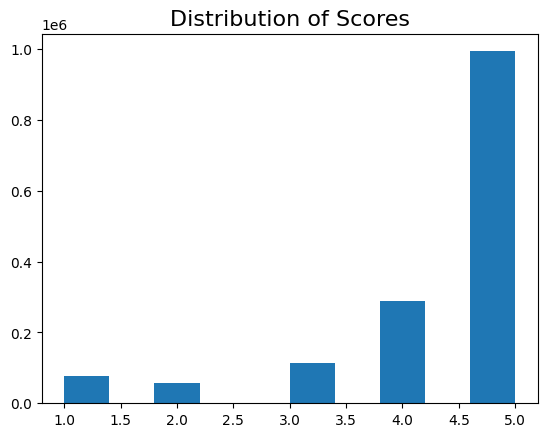

In [35]:
plt.hist(merged_df["score"].to_numpy())
plt.title("Distribution of Scores", fontsize=16)
plt.show()

In [36]:
ratings_df: pl.DataFrame = merged_df.group_by("productId").agg(
    (
        pl.col("score").len().alias("count"),
        pl.col("score").mean().round(2).alias("avg_score"),
    )
)

ratings_df.head()

productId,count,avg_score
str,u32,f32
"""B00080Z62Y""",1,3.0
"""B000AA7AYE""",8,4.25
"""B0002JP5FO""",2,3.0
"""B00004ZDZ4""",11,4.55
"""B00002MXMX""",6,4.33


In [37]:
ratings_df.describe()

statistic,productId,count,avg_score
str,str,f64,f64
"""count""","""316706""",316706.0,316706.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,4.82832,4.401333
"""std""",null,15.514468,0.839012
"""min""","""0005224896""",1.0,1.0
"""25%""",null,1.0,4.0
"""50%""",null,2.0,4.75
"""75%""",null,3.0,5.0
"""max""","""B006B9REH6""",974.0,5.0


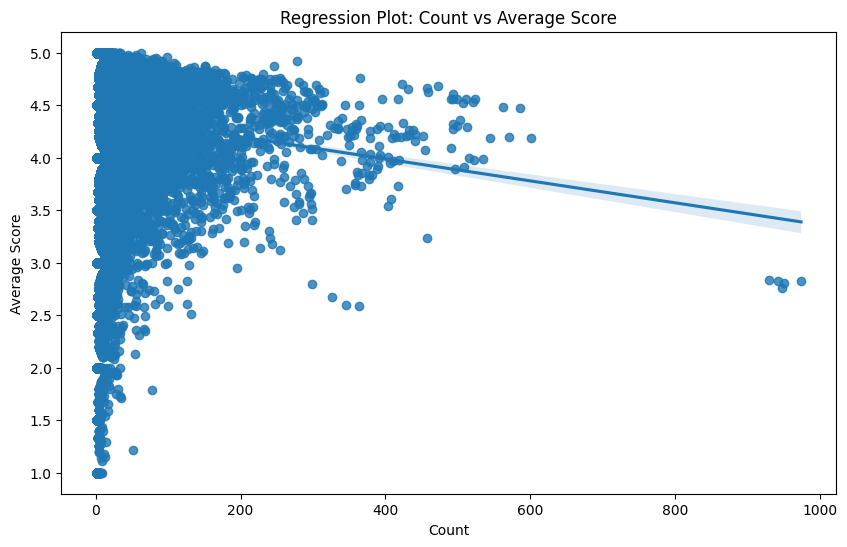

In [38]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.regplot(x="count", y="avg_score", data=ratings_df.to_pandas())
plt.title("Regression Plot: Count vs Average Score")
plt.xlabel("Count")
plt.ylabel("Average Score")
plt.show()

#### Comment:

- The correlation between the number of ratings and the ratings is negative.

In [39]:
uniq_titles_df: pl.DataFrame = merged_df.select(
    ["productId", "title", "product_category"]
).unique("title")
uniq_titles_df.shape

(231434, 3)

#### Create Metadata

- Metadata: product_category + summary

In [40]:
uniq_titles_df.head(2)

productId,title,product_category
str,str,str
"""B00000268R""","""I'm No Angel""","""Music, Pop Music, Hard Rock & Metal Music, Rock Music, Classic Rock"""
"""B00000DSFF""","""Beethoven: Symphonies Nos. 4 & 5 / Egmont Overture - Bernstein Royal Edition""","""Music, Classical"""


In [41]:
product_tags_df: pl.DataFrame = merged_df.group_by("productId").agg(
    pl.col("summary").map_elements(lambda x: " ".join(x))
)
product_tags_df.head()

productId,summary
str,str
"""B00006H6A0""","""WONDERFUL!!!"""
"""B0000076FL""","""one of the greatest"""
"""B00000G3UB""","""Great collection of friendship songs! A great combo of originals &amp; covers celebrating friendshi…"
"""B0000695MV""","""Progressive mix of rock and jazz with one commerical hit"""
"""B000065UMU""","""props solid, but not as adventerous as it could be. 3 1/2 stars"""


In [42]:
products_df: pl.DataFrame = uniq_titles_df.join(
    product_tags_df, on="productId", how="left"
)
products_df = products_df.with_columns(
    title=pl.col("title").str.to_lowercase(),
    genres=pl.col("product_category").str.replace_all(",", " "),
).with_columns(
    metadata=pl.concat_list(pl.col("summary"), pl.col("genres")).map_elements(
        lambda x: " ".join(x)
    )
)

products_df.head()

productId,title,product_category,summary,genres,metadata
str,str,str,str,str,str
"""B00000268R""","""i'm no angel""","""Music, Pop Music, Hard Rock & Metal Music, Rock Music, Classic Rock""","""S PENN HE'S NO ANGEL, BUT GREGG ALLMAN IS ONE HELL OF A SINGER ! Not Quite The Allman Brothers Band…","""Music Pop Music Hard Rock & Metal Music Rock Music Classic Rock""","""S PENN HE'S NO ANGEL, BUT GREGG ALLMAN IS ONE HELL OF A SINGER ! Not Quite The Allman Brothers Band…"
"""B00000DSFF""","""beethoven: symphonies nos. 4 & 5 / egmont overture - bernstein royal edition""","""Music, Classical""","""Choosing an older Beethoven Fifth--Kleiber, Bernstein, or Karajan?""","""Music Classical""","""Choosing an older Beethoven Fifth--Kleiber, Bernstein, or Karajan? Music Classical"""
"""B000RN19R8""","""whiskey in the jar part three""","""Music, Rock Music, World Music Music, Hard Rock & Metal""","""A splurge....""","""Music Rock Music World Music Music Hard Rock & Metal""","""A splurge.... Music Rock Music World Music Music Hard Rock & Metal"""
"""B00009YXFT""","""chris emerson""","""Music, Rock Music, Pop""","""Good tunes for all ages HIS NEW CD IS AWESOME! great music, and two new songs. yes! I really love t…","""Music Rock Music Pop""","""Good tunes for all ages HIS NEW CD IS AWESOME! great music, and two new songs. yes! I really love t…"
"""B00005O7SU""","""jazz matinee""","""Music, Jazz Music, Pop""","""Mr Mumbles meets a German big band""","""Music Jazz Music Pop""","""Mr Mumbles meets a German big band Music Jazz Music Pop"""


In [43]:
print(f"{products_df.shape = }")
products_df.select(["title", "metadata"]).head()

products_df.shape = (231434, 6)


title,metadata
str,str
"""i'm no angel""","""S PENN HE'S NO ANGEL, BUT GREGG ALLMAN IS ONE HELL OF A SINGER ! Not Quite The Allman Brothers Band…"
"""beethoven: symphonies nos. 4 & 5 / egmont overture - bernstein royal edition""","""Choosing an older Beethoven Fifth--Kleiber, Bernstein, or Karajan? Music Classical"""
"""whiskey in the jar part three""","""A splurge.... Music Rock Music World Music Music Hard Rock & Metal"""
"""chris emerson""","""Good tunes for all ages HIS NEW CD IS AWESOME! great music, and two new songs. yes! I really love t…"
"""jazz matinee""","""Mr Mumbles meets a German big band Music Jazz Music Pop"""


### Content Based Recommender System

- Recommends items based on their characteristics and a user's preferences for those characteristics.
- Convert the text into vectors using TF-IDF.
- Reduce the dimensions using SVD.

In [44]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline


n_components: int = 200
seed: int = 123
pipe: Pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2)),
        ("svd", TruncatedSVD(n_components=n_components, random_state=seed)),
    ]
)
pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')),
                ('svd', TruncatedSVD(n_components=200, random_state=123))])

In [45]:
latent_vectors = pipe.fit_transform(products_df["metadata"].to_numpy())
latent_vectors.shape

(231434, 200)

In [46]:
# latent_df: pd.DataFrame = pd.DataFrame(latent_vectors, index=products_df["title"])
title_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": products_df["title"].str.to_lowercase(),
    }
)
latent_df: pl.DataFrame = pl.concat(
    [title_df, pl.DataFrame(latent_vectors)], how="horizontal"
)
latent_df.head()

title,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91,column_92,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""i'm no angel""",0.140883,-0.058577,-0.001814,0.005349,0.009853,-0.008785,-0.005665,0.012238,0.073152,0.008462,0.026774,0.010264,0.015374,0.036193,0.002014,-0.010489,-0.010931,-0.007047,-0.002492,0.020797,0.017919,-0.02477,-0.002316,0.001457,-0.001947,0.009771,-0.001576,0.002436,0.010961,0.006314,-0.007824,0.010546,0.003527,-0.008188,0.039735,-0.04185,-0.051087,-0.002913,0.010209,0.006918,0.002969,0.006977,-0.003642,0.006167,0.001831,0.000458,-0.000343,-0.005231,0.004092,-0.004606,0.000526,0.001708,0.001731,0.009906,-0.005168,-0.005563,0.005867,-0.008659,0.022204,-0.007494,-0.009787,-0.006975,0.001811,0.000821,0.007236,-0.001854,0.006239,-0.00348,0.00024,-0.004681,-0.001346,-0.000599,-0.0042,-0.000253,0.001637,-0.002192,0.001273,0.000312,0.002894,0.0078,-0.000594,-0.000825,0.001927,-0.002669,-0.005454,-0.011623,-0.003344,0.003076,0.008012,-0.002312,0.005494,0.005783,0.002757,0.005666,-0.002214,-0.008856,0.004877,-0.000332,-0.005041,0.000775,0.00985,-0.000689,0.001042,0.005075,0.008217,0.039738,-0.0133,-0.057173,-0.010781,0.021248,-0.012796,0.028317,-0.051675,0.024934,0.032107,0.025

In [47]:
latent_df["title"].sample(n=8, seed=seed)

title
str
"""torn"""
"""live germany 1996"""
"""mathar 7 tracks"""
"""breed the killers"""
"""four & more"""
"""weiss: the london manuscript, vol. 8 / cardin"""
"""songs for the jet set 2000, vol. 3"""
"""black sabbath (limited edition)"""


In [48]:
import polars.selectors as cs

# Ignore the `title` column
latent_df.select(cs.float()).head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91,column_92,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.140883,-0.058577,-0.001814,0.005349,0.009853,-0.008785,-0.005665,0.012238,0.073152,0.008462,0.026774,0.010264,0.015374,0.036193,0.002014,-0.010489,-0.010931,-0.007047,-0.002492,0.020797,0.017919,-0.02477,-0.002316,0.001457,-0.001947,0.009771,-0.001576,0.002436,0.010961,0.006314,-0.007824,0.010546,0.003527,-0.008188,0.039735,-0.04185,-0.051087,-0.002913,0.010209,0.006918,0.002969,0.006977,-0.003642,0.006167,0.001831,0.000458,-0.000343,-0.005231,0.004092,-0.004606,0.000526,0.001708,0.001731,0.009906,-0.005168,-0.005563,0.005867,-0.008659,0.022204,-0.007494,-0.009787,-0.006975,0.001811,0.000821,0.007236,-0.001854,0.006239,-0.00348,0.00024,-0.004681,-0.001346,-0.000599,-0.0042,-0.000253,0.001637,-0.002192,0.001273,0.000312,0.002894,0.0078,-0.000594,-0.000825,0.001927,-0.002669,-0.005454,-0.011623,-0.003344,0.003076,0.008012,-0.002312,0.005494,0.005783,0.002757,0.005666,-0.002214,-0.008856,0.004877,-0.000332,-0.005041,0.000775,0.00985,-0.000689,0.001042,0.005075,0.008217,0.039738,-0.0133,-0.057173,-0.010781,0.021248,-0.012796,0.028317,-0.051675,0.024934,0.032107,0.025772,0.000526,-0.016468,0.0497

In [49]:
movie_title: str = "spiderman 2"
all_movie_vectors: np.ndarray = latent_df.select(cs.float())
movie_vector: np.ndarray = latent_df.filter(pl.col("title").eq(movie_title)).select(
    cs.float()
)
print(f"{movie_vector.shape = }")
print(f"{all_movie_vectors.shape = }")
# V @ m -> (234564, 200) @ (1, 200)
# V @ mT -> (234564, 200) @ (200, 1) -> (234564, 1)
cos_sim: float = cosine_similarity(latent_df.select(cs.float()), movie_vector)
print(f"{cos_sim.shape = }")
similarity_measure_df: pl.DataFrame = pl.DataFrame(
    {"title": latent_df["title"], "similarity": cos_sim.flatten()}
).sort(by="similarity", descending=True)

similarity_measure_df.head()

movie_vector.shape = (1, 200)
all_movie_vectors.shape = (231434, 200)
cos_sim.shape = (231434, 1)


title,similarity
str,f64
"""spiderman 2""",1.0
"""comes to your house""",0.894878
"""sweat & swim""",0.883244
"""origins of misery""",0.862244
"""collection of butchery""",0.860475


In [50]:
# Reccommend movies to users based on their preferences
N: int = 10
columns: list[str] = ["title", "product_category"]
recommend_df: pl.DataFrame = (
    similarity_measure_df.join(products_df.select(columns), on="title", how="left")
    .slice(0, N)
    .select(columns + ["similarity"])
)
recommend_df

title,product_category,similarity
str,str,f64
"""spiderman 2""","""Music, Alternative Rock Music, Hard Rock & Metal Music, Pop Music, Soundtracks""",1.0
"""comes to your house""","""Music, Pop Music, Rock Music, Hard Rock & Metal Music, Alternative Rock""",0.894878
"""sweat & swim""","""Music, Alternative Rock Music, Hard Rock & Metal Music, Rock""",0.883244
"""origins of misery""","""Music, Hard Rock & Metal Music, Rock Music, Pop""",0.862244
"""collection of butchery""","""Music, Pop Music, Hard Rock & Metal Music, Rock""",0.860475
"""mission: impossible 2: music from and inspired by (2000 film)""","""Music, Alternative Rock Music, Pop Music, Hard Rock & Metal Music, Soundtracks""",0.834602
"""jailbait""","""Music, Hard Rock & Metal Music, Pop Music, Soundtracks Music, Alternative Rock""",0.834165
"""mtv road rules""","""Music, Soundtracks Music, Pop Music, Alternative Rock Music, Hard Rock & Metal""",0.833893
"""live in nyc - 1975""","""Music, Rock Music, Hard Rock & Metal Music, Alternative Rock Music, Classic Rock Music, Pop""",0.831213


In [51]:
products_df.filter(pl.col("title").str.contains("get rich"))

productId,title,product_category,summary,genres,metadata
str,str,str,str,str,str
"""B000088E6R""","""get rich or die tryin' [vinyl]""","""Music, Rap & Hip-Hop Music, Pop""","""AnAgRaM730's Shh.......... is it worth gettin the official or bootleg??? G-G-G-G-G-UNIT!!! Well, th…","""Music Rap & Hip-Hop Music Pop""","""AnAgRaM730's Shh.......... is it worth gettin the official or bootleg??? G-G-G-G-G-UNIT!!! Well, th…"
"""B000BT7I96""","""get rich or die tryin' (ost)""","""Music, Soundtracks Music, Rap & Hip-Hop""","""The Movie and the Soundtrack 50 duz it agen GO! 50 IN A HOUSE BOUNCE!!!!!!!! came in perfect condit…","""Music Soundtracks Music Rap & Hip-Hop""","""The Movie and the Soundtrack 50 duz it agen GO! 50 IN A HOUSE BOUNCE!!!!!!!! came in perfect condit…"
"""B0007WZWHW""","""get rich or die tryin'""","""Music, Rock Music, Rap & Hip-Hop Music, Pop""","""Average at best.... This stinks Almost a legend Um..... Finally!!! The Hottest Album in 2 years thi…","""Music Rock Music Rap & Hip-Hop Music Pop""","""Average at best.... This stinks Almost a legend Um..... Finally!!! The Hottest Album in 2 years thi…"
"""B000084T18""","""get rich or die tryin""","""Music, Pop Music, Rap & Hip-Hop""","""Zero stars if possible It's Good, but it could be better Good CD! One of 50's Hottest Albums! Wack …","""Music Pop Music Rap & Hip-Hop""","""Zero stars if possible It's Good, but it could be better Good CD! One of 50's Hottest Albums! Wack …"


In [52]:
df_music.filter(pl.col("productId").str.contains("B000088E6R"))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""A3E6Y2RA5RKBW7""","""Dan""","""5/6""",5.0,"""1046217600""","""50 Cent Is The Future....""","""""Get Rich or Die Tryin"" is a contemplation of rough ghetto life from beginning to end, but it's als…"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""A12R5NK1AAJ1GU""","""Bored high-schooler""","""7/9""",1.0,"""1072396800""","""What's happened to Music? :(""","""Remember when music was about emotion? Well in case you don't, heres a hint.. life is not about pro…"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""A38LP5IU46NEMZ""","""Metalhead""","""3/3""",1.0,"""1053734400""","""A waste of time and money""","""Just when the rap game was getting too redundant and cliche, 50 Cent comes out.This album has all t…"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""unknown""","""unknown""","""3/6""",1.0,"""1071273600""","""50""","""I Love you 50!Saw you in concertBut the way you beat down on JaI think Im a going to put youre cd a…"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""unknown""","""unknown""","""0/0""",4.0,"""1044489600""","""G-G-G-G-G-G-G-Unit!!!""","""This is the first banging CD of the new year. The most anticipated rapper since the late Notorious …"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""A4GP0AXWGHG87""","""Clayton Sobol""","""0/2""",5.0,"""1051056000""","""50's a genius!""","""This is quite possibly best cd i have ever copped, 50's lyrics punch out the truth about the street…"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""A38PY1N8F3DRN6""","""christian geiner""","""8/15""",1.0,"""1049500800""","""50 cent...that's about this cd's worth""","""he had a Benz 400 SE and a Land Cruiser even before hitting one sigle note .from dealing.so ify'all…"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""A1KCSBS5KC92EK""","""Ponomo""","""0/0""",5.0,"""1044489600""","""Blazing, simply a hip hop classic""","""This album is crazy. First of all, its selling like nuts. I had to go to four stores before I got m…"
"""B000088E6R""","""Get Rich or Die Tryin' [Vinyl]""","""unknown""","""AWGAJZONNK11C""","""Kevin J. McArdle""","""0/0""",4.0,"""1044489600""","""Dope, but not a classic""","""there is more hype around 50 cent right now than anyone in the music business in a long time.....po…"
